In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Flatten, Reshape, Conv1D, Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from scipy.optimize import minimize
from sklearn.metrics import classification_report
from itertools import chain

# Load Real Data

In [2]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt", header=None).values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt", header=None).values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt", header=None).values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])


HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [7]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(60).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(60).mean()

# Loading Model

In [8]:
bs = 64
lr = 0.005
stdev = 0.05
e = 20
ks = 8
f = 24
s = 4

original_dim = 32
input_shape = (original_dim, )
intermediate_dim = 16
latent_dim = 8

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=stdev)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#ENCODER
inputs = Input(shape=(original_dim, 1), name='encoder_input')
x = Conv1D(f, ks, activation='relu', padding='valid', strides=s, name='encoder_conv1D')(inputs)
x = BatchNormalization()(x)
shape = K.int_shape(x)
x = Flatten(name='encoder_flattener')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

encoder.load_weights("encoder/")

# Generate Baseline Data

In [9]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)

n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)
x_train = (x_train - np.amin(x_train)) / (np.amax(x_train) - np.amin(x_train))

4000


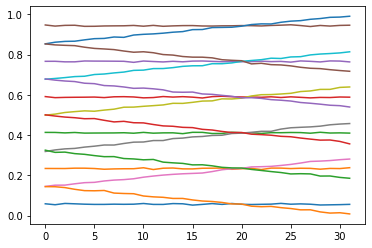

In [10]:
index = 10
interval = int(n_lines / n_types)
print(interval)
while index < n_lines:
    plt.plot(x_train[index])
    index += interval

# Calculate Baseline

In [11]:
z_test, _, _ = encoder.predict(x_train, batch_size=bs)
straight_lines_8D = z_test[:24000]
means = straight_lines_8D.mean(axis=0)
principal_axis = np.linalg.svd(straight_lines_8D - means)[2][0]
baseline_point1 = np.array([0,0,0,0,0,0,0,0], np.float32)
baseline_point2 = np.array(principal_axis, np.float32)

In [12]:
def dist(p, q, rs):
    x = p-q
    return np.linalg.norm(
        np.outer(np.dot(rs-q, x)/np.dot(x, x), x)+q-rs,
        axis=1)

# Visualize 2D

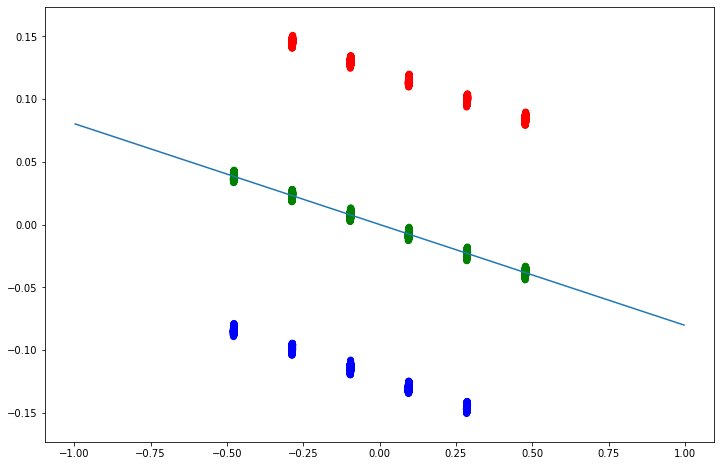

In [13]:
z_test_2D = PCA(n_components=2).fit_transform(z_test)
straight_lines_2D = z_test_2D[:24000]
means_2D = straight_lines_2D.mean(axis=0)
principal_axis_2D = np.linalg.svd(straight_lines_2D - means_2D)[2][0]
baseline_point1_2D = np.array([0,0], np.float32)
baseline_point2_2D = np.array(principal_axis_2D, np.float32)
plt.figure(figsize=(12,8))
plt.scatter(z_test_2D[:, 0], z_test_2D[:, 1],  c=y_train)
plt.plot([-baseline_point2_2D[0], baseline_point2_2D[0]], [-baseline_point2_2D[1], baseline_point2_2D[1]])

# Parameters Optimisation

In [14]:
indexes = ['1', '92', '110', '158', '286', '295', '375', '393', '460', '501', '606', '658', '675']
# indexes = ['375', '393']

In [15]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

BP_HR_validation_labels = dict()
BP_validation = dict()
HR_validation = dict()
for index in indexes:
    BPx = np.array(BP_data_scaled_averaged[index])
    HRx = np.array(HR_data_scaled_averaged[index])
    BPx = BPx[~np.isnan(BPx)]
    HRx = HRx[~np.isnan(HRx)]
    BPx = BPx[:-(BPx.shape[0] % 32)]
    HRx = HRx[:-(HRx.shape[0] % 32)]
    BPxs = np.array(np.array_split(BPx, int(len(BPx)/32)))
    HRxs = np.array(np.array_split(HRx, int(len(HRx)/32)))
    BP_HR_validation_labels[index] = np.array(['g']*len(BPxs))
    BP_validation[index] = BPxs
    HR_validation[index]= HRxs

In [16]:
index = '1'
label_func('1', 80, 81, 'r')
label_func('1', 81, 107, 'r')
label_func('1', 107, 111, 'r')
index = '375'
label_func('375', 40, 47, 'r')
label_func('375', 129, 133, 'r')
label_func('375', 133, 141, 'r')
label_func('375', 141, 144, 'r')
label_func('375', 162, 168, 'r')
index = '393' 
label_func('393', 31, 32, 'r')
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'r')
index = '92' 
label_func('92', 41, 49, 'r')
label_func('92', 140, 143, 'r')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'r')
label_func('110', 120, 123, 'r')
label_func('110', 123, 125, 'r')
index = '158' 
label_func('158', 24, 28, 'r')
label_func('158', 115, 116, 'r')
label_func('158', 116, 122, 'r')
label_func('158', 122, 123, 'r')
index = '286' 
label_func('286', 61, 62, 'r')
label_func('286', 62, 65, 'r')
label_func('286', 65, 67, 'r')
label_func('286', 123, 124, 'r')
label_func('286', 124, 129, 'r')
label_func('286', 129, 131, 'r')
label_func('286', 131, 134, 'r')
index = '295' 
label_func('295', 131, 134, 'r')
label_func('295', 134, 144, 'r')
index = '460' 
label_func('460', 49, 50, 'r')
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'r')
index = '501'
label_func('501', 119, 120, 'r')
label_func('501', 120, 124, 'r')
label_func('501', 124, 125, 'r')
index = '606'
label_func('606', 59, 61, 'r')
label_func('606', 61, 70, 'r')
label_func('606', 70, 72, 'r')
index = '658', 
label_func('658', 35, 36, 'r')
label_func('658', 36, 53, 'r')
label_func('658', 53, 55, 'r')
index ='675', 
label_func('675', 80, 82, 'r')
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'r')

In [17]:
N_SAMPLES_MEMORY = 5
SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)

def check_severity(HR_line_8D, BP_line_8D, a, b):
    global SEVERITY_ACC
    distance = sum(dist(baseline_point1, baseline_point2, np.array([BP_line_8D[0], HR_line_8D[0]])))
    SEVERITY_ACC = np.append(SEVERITY_ACC, distance)
    averaged_distance = SEVERITY_ACC[-N_SAMPLES_MEMORY:].mean()
    anomaly_score = distance + averaged_distance
    
    if distance > a:
        return 'r'
    if averaged_distance > b:
        return 'r'
    return 'g' 

In [18]:
def sample_timeseries(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if x.shape[0] % 32 != 0:
        x = x[:-(x.shape[0] % 32)]
    return np.array(np.array_split(x, int(len(x)/32)))

In [78]:
classification_reports = dict()

def calc_accuracy_for_params(params):
    start = time.time()
    a, b = params
    global SEVERITY_ACC
    y_pred = np.array([])
    
    for i in indexes:
        HR = sample_timeseries(HR_data_scaled_averaged[i])
        BP = sample_timeseries(BP_data_scaled_averaged[i])
        SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)  
        for HRv, BPv, label in zip(HR, BP, BP_HR_validation_labels[i]):
            BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
            HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
            severity = check_severity(HR_line_8D, BP_line_8D, a, b)
            y_pred = np.append(y_pred, severity)
            
    y_true = np.array(list(chain(*BP_HR_validation_labels.values())), dtype=str)    
    class_report = classification_report(y_true, y_pred, output_dict=True)
    acc = class_report['accuracy']
    red_f1 = class_report['r']['f1-score']
    green_f1 = class_report['g']['f1-score']
    classification_reports[(a, b)] = class_report
    print(f"Accuracy: {acc:.4f}, Green F1: {green_f1:.4f}, Red F1: {red_f1:.4f}, a: {a:.3f}, b: {b:.3f}, time:{(time.time() - start):.2f}s")

In [79]:
aa = np.array(range(50, 62, 2)) / 1000
bb = np.array(range(38, 43, 1)) / 1000
print(aa)
print(bb)

[0.05  0.052 0.054 0.056 0.058 0.06 ]
[0.038 0.039 0.04  0.041 0.042]


In [80]:
for b in bb:
    for a in aa:
        calc_accuracy_for_params([a, b])

Accuracy: 0.8931, Green F1: 0.9377, Red F1: 0.6241, a: 0.050, b: 0.038, time:87.36s
Accuracy: 0.8944, Green F1: 0.9386, Red F1: 0.6235, a: 0.052, b: 0.038, time:87.90s
Accuracy: 0.8985, Green F1: 0.9412, Red F1: 0.6290, a: 0.054, b: 0.038, time:88.02s
Accuracy: 0.8998, Green F1: 0.9421, Red F1: 0.6284, a: 0.056, b: 0.038, time:87.57s
Accuracy: 0.9025, Green F1: 0.9438, Red F1: 0.6329, a: 0.058, b: 0.038, time:88.31s
Accuracy: 0.9018, Green F1: 0.9434, Red F1: 0.6294, a: 0.060, b: 0.038, time:88.10s
Accuracy: 0.8991, Green F1: 0.9415, Red F1: 0.6324, a: 0.050, b: 0.039, time:88.01s
Accuracy: 0.9005, Green F1: 0.9425, Red F1: 0.6318, a: 0.052, b: 0.039, time:88.38s
Accuracy: 0.9045, Green F1: 0.9450, Red F1: 0.6378, a: 0.054, b: 0.039, time:88.77s
Accuracy: 0.9059, Green F1: 0.9459, Red F1: 0.6373, a: 0.056, b: 0.039, time:88.07s
Accuracy: 0.9085, Green F1: 0.9476, Red F1: 0.6421, a: 0.058, b: 0.039, time:88.18s
Accuracy: 0.9079, Green F1: 0.9472, Red F1: 0.6385, a: 0.060, b: 0.039, time

In [68]:
for b in bb:
    for a in aa:
        calc_accuracy_for_params([a, b])

Accuracy: 0.6940, Red Precision: 0.2867, a: 0.040, b: 0.030, time:87.36s
Accuracy: 0.7095, Red Precision: 0.2978, a: 0.045, b: 0.030, time:85.28s
Accuracy: 0.7149, Red Precision: 0.3007, a: 0.050, b: 0.030, time:88.19s
Accuracy: 0.7149, Red Precision: 0.2993, a: 0.055, b: 0.030, time:84.57s
Accuracy: 0.7162, Red Precision: 0.3004, a: 0.060, b: 0.030, time:84.84s
Accuracy: 0.8238, Red Precision: 0.4242, a: 0.040, b: 0.035, time:84.75s
Accuracy: 0.8507, Red Precision: 0.4774, a: 0.045, b: 0.035, time:85.10s
Accuracy: 0.8662, Red Precision: 0.5162, a: 0.050, b: 0.035, time:87.61s
Accuracy: 0.8682, Red Precision: 0.5226, a: 0.055, b: 0.035, time:84.78s
Accuracy: 0.8709, Red Precision: 0.5312, a: 0.060, b: 0.035, time:84.71s


In [69]:
for b in bb:
    for a in aa:
        acc = classification_reports[(a,b)]['accuracy']
        red_f1 = classification_reports[(a,b)]['r']['f1-score']
        green_f1 = classification_reports[(a,b)]['g']['f1-score']
        print(f"Accuracy: {acc:.4f}, Green F1: {green_f1:.4f}, Red F1: {red_f1:.4f}, a: {a:.3f}, b: {b:.3f}")

Accuracy: 0.6940, Green F1: 0.7920, Red F1: 0.4219, a: 0.040, b: 0.030
Accuracy: 0.7095, Green F1: 0.8047, Red F1: 0.4331, a: 0.045, b: 0.030
Accuracy: 0.7149, Green F1: 0.8094, Red F1: 0.4347, a: 0.050, b: 0.030
Accuracy: 0.7149, Green F1: 0.8097, Red F1: 0.4316, a: 0.055, b: 0.030
Accuracy: 0.7162, Green F1: 0.8108, Red F1: 0.4328, a: 0.060, b: 0.030
Accuracy: 0.8238, Green F1: 0.8913, Red F1: 0.5355, a: 0.040, b: 0.035
Accuracy: 0.8507, Green F1: 0.9096, Red F1: 0.5714, a: 0.045, b: 0.035
Accuracy: 0.8662, Green F1: 0.9200, Red F1: 0.5897, a: 0.050, b: 0.035
Accuracy: 0.8682, Green F1: 0.9216, Red F1: 0.5865, a: 0.055, b: 0.035
Accuracy: 0.8709, Green F1: 0.9235, Red F1: 0.5862, a: 0.060, b: 0.035


In [63]:
for b in bb:
    for a in aa:
        calc_accuracy_for_params([a, b])

Accuracy: 0.8547, Red Precision: 0.4856, a: 0.040, b: 0.040, time:85.89s
Accuracy: 0.8837, Red Precision: 0.5792, a: 0.045, b: 0.040, time:86.83s
Accuracy: 0.8998, Red Precision: 0.6630, a: 0.050, b: 0.040, time:87.42s
Accuracy: 0.9059, Red Precision: 0.7073, a: 0.055, b: 0.040, time:85.21s
Accuracy: 0.9099, Red Precision: 0.7467, a: 0.060, b: 0.040, time:85.02s
Accuracy: 0.9079, Red Precision: 0.7415, a: 0.065, b: 0.040, time:84.98s
Accuracy: 0.9072, Red Precision: 0.7431, a: 0.070, b: 0.040, time:85.45s
Accuracy: 0.9072, Red Precision: 0.7465, a: 0.075, b: 0.040, time:86.95s
Accuracy: 0.9065, Red Precision: 0.7447, a: 0.080, b: 0.040, time:86.44s
Accuracy: 0.8554, Red Precision: 0.4862, a: 0.040, b: 0.045, time:85.22s
Accuracy: 0.8830, Red Precision: 0.5895, a: 0.045, b: 0.045, time:85.46s
Accuracy: 0.8998, Red Precision: 0.7063, a: 0.050, b: 0.045, time:86.77s
Accuracy: 0.9052, Red Precision: 0.7815, a: 0.055, b: 0.045, time:85.74s
Accuracy: 0.9065, Red Precision: 0.8485, a: 0.060, 

In [65]:
for b in bb:
    for a in aa:
        acc = classification_reports[(a,b)]['accuracy']
        red_f1 = classification_reports[(a,b)]['r']['f1-score']
        green_f1 = classification_reports[(a,b)]['g']['f1-score']
        print(f"Accuracy: {acc:.4f}, Green F1: {green_f1:.4f}, Red F1: {red_f1:.4f}, a: {a:.3f}, b: {b:.3f}")

Accuracy: 0.8547, Green F1: 0.9132, Red F1: 0.5556, a: 0.040, b: 0.040
Accuracy: 0.8837, Green F1: 0.9320, Red F1: 0.5967, a: 0.045, b: 0.040
Accuracy: 0.8998, Green F1: 0.9424, Red F1: 0.6170, a: 0.050, b: 0.040
Accuracy: 0.9059, Green F1: 0.9462, Red F1: 0.6237, a: 0.055, b: 0.040
Accuracy: 0.9099, Green F1: 0.9488, Red F1: 0.6257, a: 0.060, b: 0.040
Accuracy: 0.9079, Green F1: 0.9477, Red F1: 0.6141, a: 0.065, b: 0.040
Accuracy: 0.9072, Green F1: 0.9474, Red F1: 0.6080, a: 0.070, b: 0.040
Accuracy: 0.9072, Green F1: 0.9474, Red F1: 0.6057, a: 0.075, b: 0.040
Accuracy: 0.9065, Green F1: 0.9470, Red F1: 0.6017, a: 0.080, b: 0.040
Accuracy: 0.8554, Green F1: 0.9144, Red F1: 0.5336, a: 0.040, b: 0.045
Accuracy: 0.8830, Green F1: 0.9325, Red F1: 0.5628, a: 0.045, b: 0.045
Accuracy: 0.8998, Green F1: 0.9432, Red F1: 0.5755, a: 0.050, b: 0.045
Accuracy: 0.9052, Green F1: 0.9467, Red F1: 0.5688, a: 0.055, b: 0.045
Accuracy: 0.9065, Green F1: 0.9479, Red F1: 0.5472, a: 0.060, b: 0.045
Accura

In [70]:
classification_reports

{(0.04,
  0.04): {'g': {'precision': 0.9396195202646815,
   'recall': 0.8881939014855356,
   'f1-score': 0.9131832797427653,
   'support': 1279}, 'r': {'precision': 0.4856115107913669,
   'recall': 0.6490384615384616,
   'f1-score': 0.5555555555555556,
   'support': 208}, 'accuracy': 0.8547410894418291, 'macro avg': {'precision': 0.7126155155280243,
   'recall': 0.7686161815119985,
   'f1-score': 0.7343694176491604,
   'support': 1487}, 'weighted avg': {'precision': 0.8761133561957849,
   'recall': 0.8547410894418291,
   'f1-score': 0.8631586888678899,
   'support': 1487}},
 (0.045,
  0.04): {'g': {'precision': 0.9368088467614534,
   'recall': 0.9272869429241595,
   'f1-score': 0.9320235756385068,
   'support': 1279}, 'r': {'precision': 0.579185520361991,
   'recall': 0.6153846153846154,
   'f1-score': 0.5967365967365967,
   'support': 208}, 'accuracy': 0.8836583725622058, 'macro avg': {'precision': 0.7579971835617222,
   'recall': 0.7713357791543874,
   'f1-score': 0.7643800861875518,

<IPython.core.display.Javascript object>


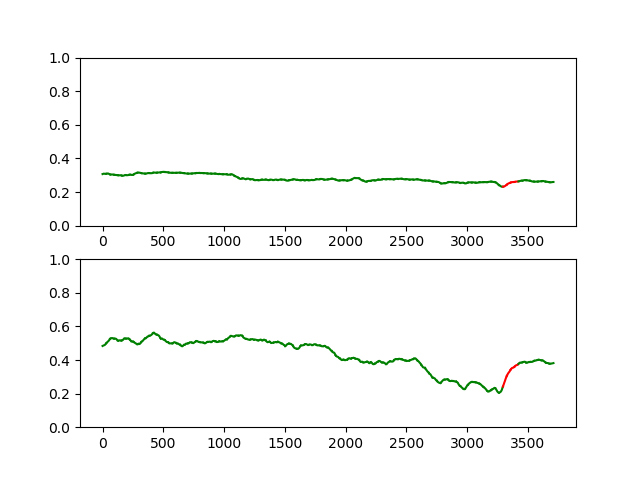

In [82]:
%matplotlib notebook
plt.ion()

n = '375'
HR = sample_timeseries(HR_data_scaled_averaged[n])
BP = sample_timeseries(BP_data_scaled_averaged[n])

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.set_ylim(0,1)
ax2 = fig1.add_subplot(212)
ax2.set_ylim(0,1)

t = 0
SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)
BP_last_elem = None
for HRv, BPv in zip(HR, BP):
    if BP_last_elem == None:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D, 0.185, 0.060)

        ax1.plot(range(t, t + len(HRv)), HRv, color=f'{c}', linestyle='-')
        ax2.plot(range(t, t + len(BPv)), BPv, color=f'{c}', linestyle='-')

        t += len(BPv)
    else:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D, 0.185, 0.060)

        time_range = range(t-1, t + len(BPv)) 
        BPv = np.concatenate(([BP_last_elem], BPv))
        HRv = np.concatenate(([HR_last_elem], HRv))
        ax1.plot(time_range, HRv, color=f'{c}', linestyle='-')
        ax2.plot(time_range, BPv, color=f'{c}', linestyle='-')

        t += len(BPv) - 1
    fig1.canvas.draw()
    BP_last_elem = BPv[-1]
    HR_last_elem = HRv[-1] 